In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io.idl import readsav
from scipy.signal import find_peaks
import pickle 
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel
from spectral_cube import SpectralCube
from astropy import units as u
import numpy.ma as ma
from astropy.stats import sigma_clip
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
import mpl_toolkits.axes_grid1.axes_grid as axes_grid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from mpl_toolkits.axes_grid.colorbar import colorbar
from matplotlib.patches import Ellipse
import math
from matplotlib import cm
from astropy.wcs import WCS
import scipy
import scipy.ndimage as ndi
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import pkg_resources
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from __future__ import print_function
import pyspeckit
import pylab as pl
import csv
import pandas as pd

In [2]:
path = 'J0454-8101_HCOp.pbcor.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header
print(header)

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    4                                                  NAXIS1  =                  432                                                  NAXIS2  =                  432                                                  NAXIS3  =                 1918                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   1.013892771516E-03                                                  BMIN    =   4.256117424470E-04                                                  BPA     =   6.762153111205E+01          

In [3]:
def integrated_optical_depth(source = 'NGC7469', molecule = 'HCOp'):
    
    #Start off by finding the continuum flux density
    path = source + '_' + molecule + '.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    squeezed_data = data[0, :, :, :]
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    #Converting from Frequeny to Velocity
    frequency_start = header["CRVAL3"]
    frequency_inc = header["CDELT3"]

    channels2 = np.arange(header["NAXIS3"])

    frequency = frequency_start + (frequency_inc * channels2)
    #frequency = np.array(frequency, dtype = float)

    i_frequency = header["RESTFRQ"]
    velocity = (3E8*((i_frequency - frequency)/i_frequency))/1000
    velocity = np.array(velocity, dtype = float)
    velocity_diff = velocity[1]- velocity[0]
    
    #Defining the brightest pixel for each point source based on previous findings
    if source == 'NGC7714': 
        x1 = round(header["CRPIX1"]-(ra_start-354.058992)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-2.155161)/dec_inc)-1
        array = np.arange(700, 850, 1)
        if molecule == 'HCOp':
            cont_flux_density = 0.002437
        elif molecule == 'HCN':
            cont_flux_density = 0.002437
        elif molecule == 'HNC':
            cont_flux_density = 0.002437
        elif molecule == 'CCH':
            cont_flux_density = 0.002437
    elif source == '2331p073':
        x1 = round(header["CRPIX1"]-(ra_start-353.5534454167)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-7.60773555555577)/dec_inc)-1
        array = np.arange(0, 1900, 1)
        if molecule == 'HCOp':
            cont_flux_density = 0.5624284
        elif molecule == 'HCN':
            cont_flux_density = 0.5624284
        elif molecule == 'HNC':
            cont_flux_density = 0.5624284
        elif molecule == 'CCH':
            cont_flux_density = 0.5624284
    elif source == 'J0635-7516':
        x1 = round(header["CRPIX1"]-(ra_start-98.94376041667)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+75.27133638889)/dec_inc)-1
        array = np.arange(0, 1900, 1)
        if molecule == 'HCOp':
            cont_flux_density = 1.44099
        elif molecule == 'HCN':
            cont_flux_density = 1.44099
        elif molecule == 'HNC':
            cont_flux_density = 1.43212
        elif molecule == 'CCH':
            cont_flux_density = 1.47759
    elif source == '2355-534':
        x1 = round(header["CRPIX1"]-(ra_start-359.47194)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+53.18713138889)/dec_inc)-1
        array = np.arange(0, 1900, 1)
        if molecule == 'HCOp':
            cont_flux_density = 1.0695
        elif molecule == 'HCN':
            cont_flux_density = 1.0695
        elif molecule == 'HNC':
            cont_flux_density = 1.0695
        elif molecule == 'CCH':
            cont_flux_density = 1.0695
    elif source == '2326-477':
        x1 = round(header["CRPIX1"]-(ra_start-352.323767)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+47.505308)/dec_inc)-1
        array = np.arange(700, 850, 1)
        if molecule == 'HCOp':
            cont_flux_density = 0.673318
        elif molecule == 'HCN':
            cont_flux_density = 0.673318
        elif molecule == 'HNC':
            cont_flux_density = 0.673318
        elif molecule == 'CCH':
            cont_flux_density = 0.673318
    elif source == 'J1058-8003':
        x1 = round(header["CRPIX1"]-(ra_start-164.6804358333)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+80.0650038888866)/dec_inc)-1
        array = np.arange(700, 825, 1)
        if molecule == 'HCOp':
            cont_flux_density = 1.462958
        elif molecule == 'HCN':
            cont_flux_density = 1.462958
        elif molecule == 'HNC':
            cont_flux_density = 1.462958
        elif molecule == 'CCH':
            cont_flux_density = 1.462958
    elif source == 'J0454-8101':
        x1 = round(header["CRPIX1"]-(ra_start-72.5227836111144)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+81.0172111111077)/dec_inc)-1
        array = np.arange(700, 850, 1)
        if molecule == 'HCOp':
            cont_flux_density = 2.135
        elif molecule == 'HCN':
            cont_flux_density = 2.135
        elif molecule == 'HNC':
            cont_flux_density = 2.135
        elif molecule == 'CCH':
            cont_flux_density = 2.135
    elif source == '2345-167':
        x1 = round(header["CRPIX1"]-(ra_start-357.0108633333)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+16.52000166667)/dec_inc)-1
        array = np.arange(0, 1900, 1)
        if molecule == 'HCOp':
            cont_flux_density = 3.20197
        elif molecule == 'HCN':
            cont_flux_density = 3.20197
        elif molecule == 'HNC':
            cont_flux_density = 3.20197
        elif molecule == 'CCH':
            cont_flux_density = 3.20197
    elif source == 'J2230+114':
        x1 = round(header["CRPIX1"]-(ra_start-338.1516991667)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-11.73081027778)/dec_inc)-1
        array = np.arange(0, 1900, 1)
        if molecule == 'HCOp':
            cont_flux_density = 3.01255
        elif molecule == 'HCN':
            cont_flux_density = 3.01255
        elif molecule == 'HNC':
            cont_flux_density = 3.01255
        elif molecule == 'CCH':
            cont_flux_density = 3.01255
    elif source == 'J0049-4457':
        x1 = round(header["CRPIX1"]-(ra_start-12.31926375)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+44.95309611111)/dec_inc)-1
        array = np.arange(0, 1900, 1)
        if molecule == 'HCOp':
            cont_flux_density = 0.28565
        elif molecule == 'HCN':
            cont_flux_density = 0.28565
        elif molecule == 'HNC':
            cont_flux_density = 0.28565
        elif molecule == 'CCH':
            cont_flux_density = 0.28565
    
    spectrum = squeezed_data[:, y1, x1]

    #array = np.arange(0, 1900, 1)
    decimated_xvals = (velocity[array])[::10]
    x = decimated_xvals[1:]
    
    entau = (spectrum)/cont_flux_density
    #This is the e^-tau spectrum, so get tau first, then integrate
    #This e^-tau is the optical depth spectrum
    
    tau = -np.log(entau)
    #I believe the tau spectrum in the absorption spectrum
    
    smoothing_15 = convolve(entau, Box1DKernel(30))
    smoothed_decimated_spect = smoothing_15[::30]
    spect = smoothed_decimated_spect[1:]
    
    o_smoothing_15 = convolve(tau[array], Box1DKernel(10))
    o_smoothed_decimated_spect = o_smoothing_15[::10]
    o_spect = o_smoothed_decimated_spect[1:]
    
    plt.figure(figsize=[10,8])
    
    plt.plot(velocity[array], entau[array], label = 'Optical Depth Spectrum')
    
    peaks, properties = find_peaks(tau[array], height = np.amax(tau[array]), width = 1) #Requirements to identify peaks
    prominences = properties["prominences"] #vertical distance between the peak and its lowest contour line
    heights = properties["peak_heights"]
    widths = properties["widths"] #width of a peak in samples
    width_heights = properties["width_heights"] #height of the contour lines at which the widths where evaluated
    
    def gaussian(x, amp, cen, wid):
        return amp * np.exp(-(x-cen)**2 / wid)
    
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Optical Depth')
    plt.title('Optical Depth Spectrum '+ source + ' for ' + molecule, fontsize=16)
    plt.legend()
    plt.grid()
    
    #plt.savefig(source + '_'+ molecule + '_Optical_Depth_Spect_9_27.png')
    
    #squared = (tau[array])**2
    #rms = math.sqrt(np.sum(squared)/len(tau[array]))
    #print('RMS =', rms)
    
    array2 = np.arange(1800, 1900, 1)
    #print(source, molecule)
    #print('mean value =', np.nanmean(tau[array2]))
    std_dev1 = tau[array] - np.nanmean(tau[array2])
    std_dev2 = std_dev1**2
    std_dev3 = np.sum(std_dev2)
    std_dev4 = std_dev3/len(tau[array2])
    std_dev5 = math.sqrt(std_dev4)
    #print('Standard Deviation =', std_dev5)
    upper_limits = std_dev5*1.064*3*2*1.11e11
    print(source, molecule, upper_limits)
    
    #sigma clipping
    
    #int_opt_depth = np.nansum(tau[array], axis=0)*velocity_diff
    #print('Inegrated Optical Depth =', int_opt_depth)

2331p073 CCH 61273533783.438255
J0635-7516 CCH 27457330544.270977
2355-534 CCH 29517954672.783733
J1058-8003 CCH 7987618466.521339
J0454-8101 HNC 6276045320.536643
2345-167 CCH 14793794059.587725
J2230+114 CCH 12238704695.760767


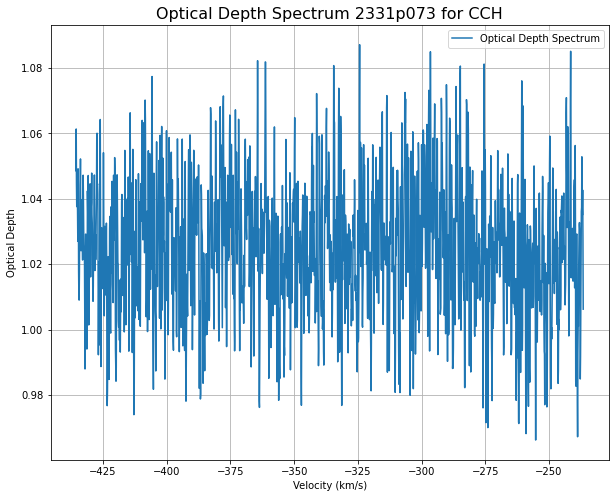

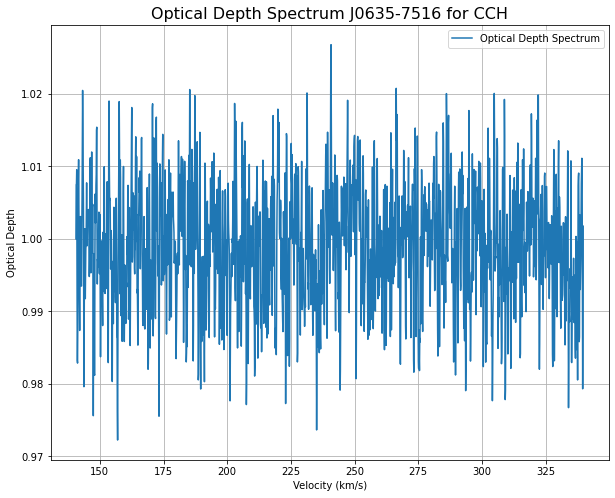

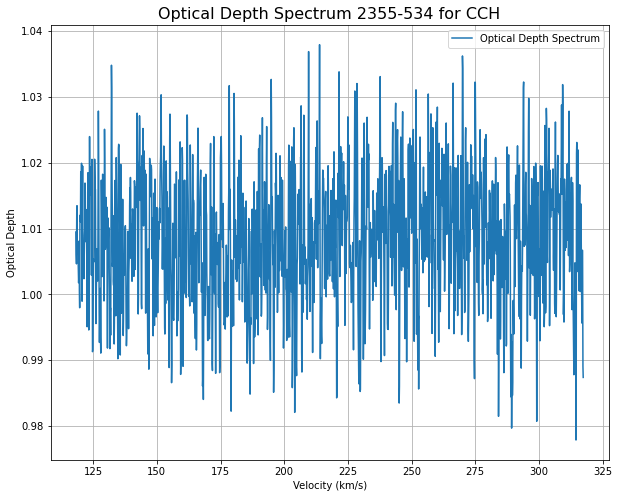

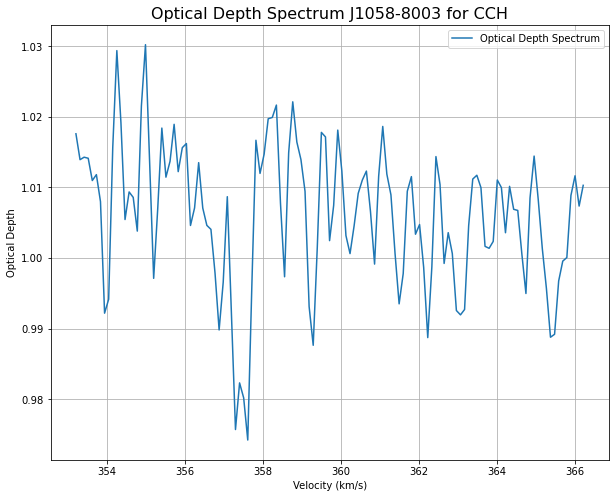

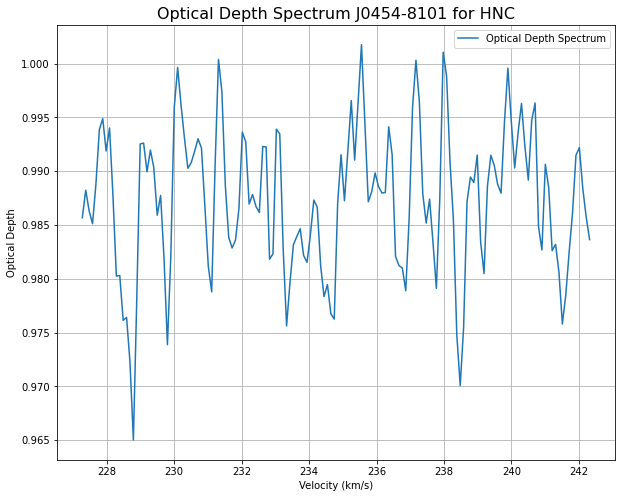

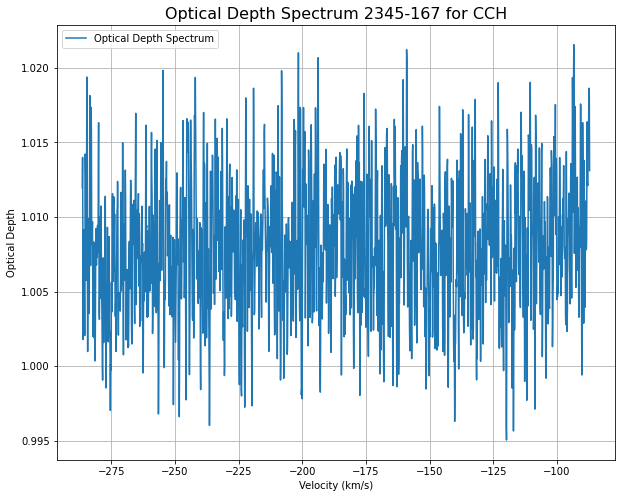

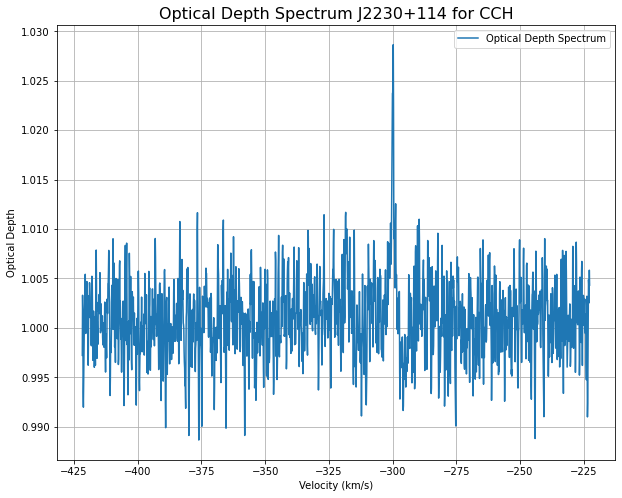

In [4]:
#integrated_optical_depth(source = '2331p073', molecule = 'HCN')
integrated_optical_depth(source = '2331p073', molecule = 'CCH')
#integrated_optical_depth(source = '2331p073', molecule = 'HNC')
#integrated_optical_depth(source = '2331p073', molecule = 'HCOp')

#integrated_optical_depth(source = 'J0635-7516', molecule = 'HCN')
integrated_optical_depth(source = 'J0635-7516', molecule = 'CCH')
#integrated_optical_depth(source = 'J0635-7516', molecule = 'HNC')
#integrated_optical_depth(source = 'J0635-7516', molecule = 'HCOp')

#integrated_optical_depth(source = '2355-534', molecule = 'HCN')
integrated_optical_depth(source = '2355-534', molecule = 'CCH')
#integrated_optical_depth(source = '2355-534', molecule = 'HNC')
#integrated_optical_depth(source = '2355-534', molecule = 'HCOp')

#integrated_optical_depth(source = 'J1058-8003', molecule = 'HCN')
integrated_optical_depth(source = 'J1058-8003', molecule = 'CCH')
#integrated_optical_depth(source = 'J1058-8003', molecule = 'HNC')
#integrated_optical_depth(source = 'J1058-8003', molecule = 'HCOp')

#integrated_optical_depth(source = 'J0454-8101', molecule = 'HCN')
#integrated_optical_depth(source = 'J0454-8101', molecule = 'CCH')
integrated_optical_depth(source = 'J0454-8101', molecule = 'HNC')
#integrated_optical_depth(source = 'J0454-8101', molecule = 'HCOp')

#integrated_optical_depth(source = '2345-167', molecule = 'HCN')
integrated_optical_depth(source = '2345-167', molecule = 'CCH')
#integrated_optical_depth(source = '2345-167', molecule = 'HNC')
#integrated_optical_depth(source = '2345-167', molecule = 'HCOp')

#integrated_optical_depth(source = 'J2230+114', molecule = 'HCN')
integrated_optical_depth(source = 'J2230+114', molecule = 'CCH')
#integrated_optical_depth(source = 'J2230+114', molecule = 'HNC')
#integrated_optical_depth(source = 'J2230+114', molecule = 'HCOp')

#integrated_optical_depth(source = 'J0049-4457', molecule = 'HCN')
#integrated_optical_depth(source = 'J0049-4457', molecule = 'CCH')
#integrated_optical_depth(source = 'J0049-4457', molecule = 'HNC')
#integrated_optical_depth(source = 'J0049-4457', molecule = 'HCOp')

<_io.TextIOWrapper name='Magellanic Stream Column Density.csv' mode='r' encoding='cp1252'>
[91.885, -106.368, -140.185, -118.009, -113.851, 77.438, 65.53699999999999, -124.181]
[-50.55, -27.158, -62.111000000000004, -18.288, -31.371, -38.582, -71.892, -72.17]


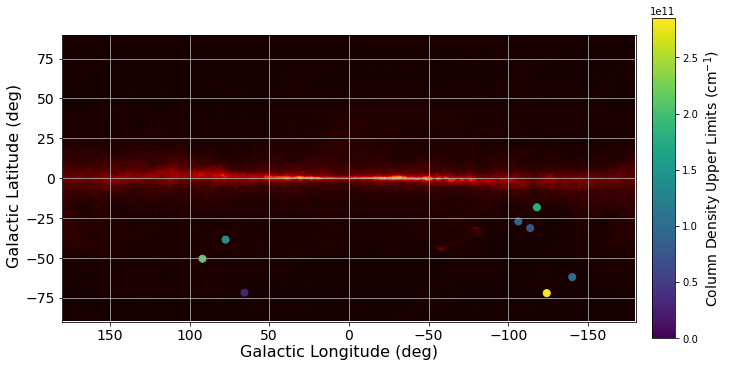

In [37]:
source = 'Magellanic Stream Column Density.csv'
#csv.reader(source)

file = open(source)
print(file)

csvreader = csv.reader(file)
print(csvreader)

data = pd.read_csv(source)
l_float = [float(x) for x in data['Galactic Longitude']]
b_float = [float(x) for x in data['Galactic Latitude']]
HCOp_float = [float(x) for x in data['HCO+']]
HCN_float = [float(x) for x in data['HCN']]
HNC_float = [float(x) for x in data['HNC']]
CCH_float = [float(x) for x in data['CCH']]

print(l_float)
print(b_float)

path = 'CAR_-600_600.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header

lon_start = header["CRVAL1"]
lon_inc = header["CDELT1"]

lon_channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

lon = lon_start + (lon_inc * lon_channels)
lon = np.array(lon, dtype = float)

lat_start = header["CRVAL2"]
lat_inc = header["CDELT2"]

lat_channels = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

lat = lat_start + (lat_inc * lat_channels)
lat = np.array(lat, dtype = float)

#plt.figure(figsize = [10,10])
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [25, 1]}, figsize = [10, 5])

color_map = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=5, vmax=np.max(HCOp_float))

scalar_map = mpl.cm.ScalarMappable(norm=norm, cmap=color_map)
mapped_colors = scalar_map.to_rgba(HCOp_float)

cb1 = mpl.colorbar.ColorbarBase(ax[1], cmap=color_map, norm=norm, orientation='vertical')
cb1.set_label('Column Density Upper Limits (cm$^{-1}$)', fontsize = 14)

ax[0].scatter(l_float, b_float, color = mapped_colors, s = 50)
ax[0].imshow(data, origin='lower', cmap='gist_heat', extent = [lon[0], lon[-1], lat[0], lat[-1]])
ax[0].grid()
#ax[0].set_xticks([-150, -100, -50, 0, 50, 100, 150], fontsize = 12)
ax[0].tick_params(axis = 'both', labelsize = 14)
#print(mapped_colors[0])

#fig.suptitle('Column Density of C$_2$H in the Magellanic Stream', fontsize=18, y=0.97, horizontalalignment='center', verticalalignment='center')
#ax[0]

fig.text(0.45, -0.01, 'Galactic Longitude (deg)',fontsize=16, horizontalalignment='center', verticalalignment='bottom')
fig.text(0.0, 0.5, 'Galactic Latitude (deg)',fontsize=16, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
fig.tight_layout()

plt.savefig('HCOp_Mapping.png', bbox_inches = 'tight')

<_io.TextIOWrapper name='Magellanic Stream Column Density.csv' mode='r' encoding='cp1252'>


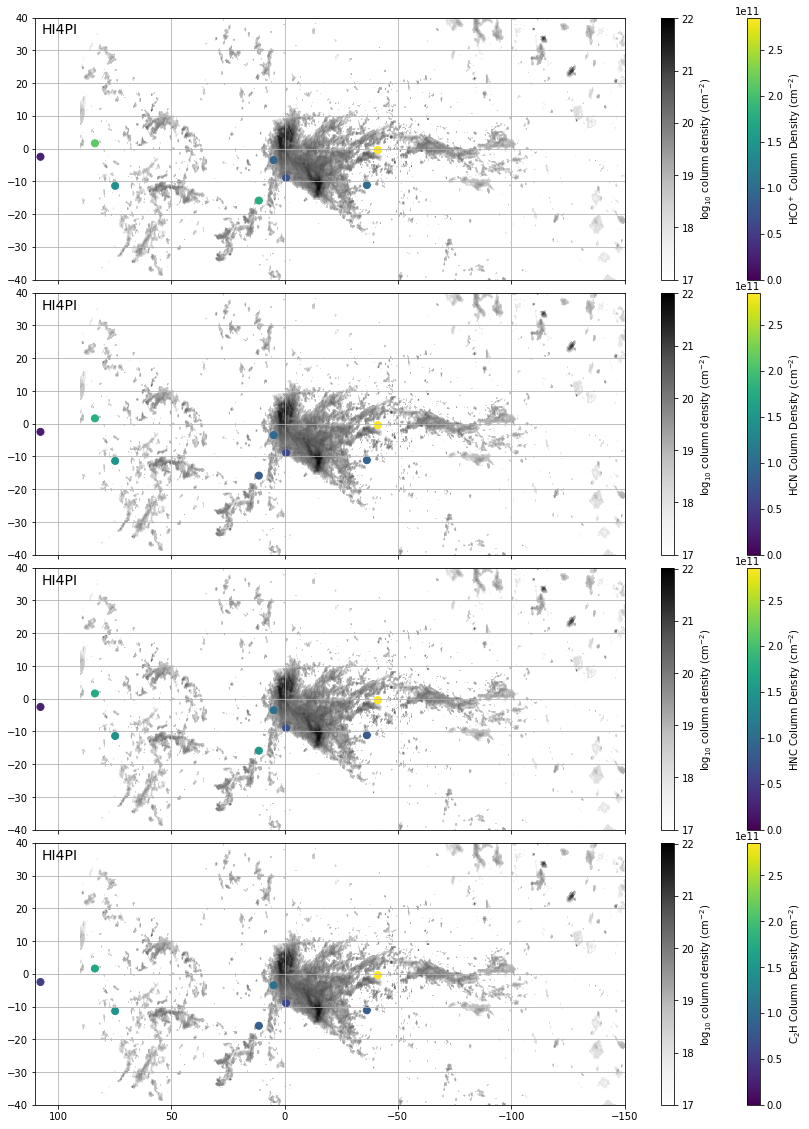

In [51]:
import numpy as np, matplotlib.pyplot as plt
from astropy.io import fits

def linear_coords(header, axis=1):
    crpix = header['CRPIX%d' % axis] - 1
    cdelt = header['CDELT%d' % axis]
    crval = header['CRVAL%d' % axis]
    npix = header['NAXIS%d' % axis]
    return (np.arange(npix) - crpix)*cdelt + crval

with fits.open('LAB_coldens_log.fits') as f:
    head = f[0].header
    all_ms_coldens = f[0].data

mlon_hi = linear_coords(head, 1)
mlat_hi = linear_coords(head, 2)
MLON, MLAT = np.meshgrid(mlon_hi, mlat_hi)
surface = np.ma.masked_array(all_ms_coldens, mask=np.isnan(all_ms_coldens))
# surface_dens = np.nanmax(all_ms_coldens, axis=0)
surface_dens = np.log10(np.nansum(10**all_ms_coldens, axis=0))

with fits.open("hi4pi-hvc-nhi-mag-car.fits") as f:
    head = f[0].header
    hi4pi_data = f[0].data

hi4pi_MLON,hi4pi_MLAT = np.meshgrid(linear_coords(head,1),linear_coords(head,2))
hi4pi_data[np.isnan(hi4pi_data)] = np.nanmin(hi4pi_data)

#print(hi4pi_MLAT)

fig,ax = plt.subplots(4,1,figsize=(15,20), sharex=True)
plt.subplots_adjust(hspace=0.05)

#c1 = ax[0].pcolormesh(MLON,MLAT,surface,cmap='Greys',vmin=17)
#ax[0].set_xlim(mlon_hi[-1],mlon_hi[0])
#ax[0].text(0.01,0.98,'LAB',fontsize=14,ha='left',va='top',transform=ax[0].transAxes)
#plt.colorbar(c1,ax=ax[0],label='log$_{10}$ column density (cm$^{-2}$)')

c1 = ax[0].pcolormesh(hi4pi_MLON,hi4pi_MLAT,hi4pi_data,vmin=17,cmap='Greys')
ax[0].set_xlim([110,-150])
ax[0].set_ylim([-40,40])
ax[0].text(0.01,0.98,'HI4PI',fontsize=14,ha='left',va='top',transform=ax[0].transAxes)

c2 = ax[1].pcolormesh(hi4pi_MLON,hi4pi_MLAT,hi4pi_data,vmin=17,cmap='Greys')
ax[1].set_xlim([110,-150])
ax[1].set_ylim([-40,40])
ax[1].text(0.01,0.98,'HI4PI',fontsize=14,ha='left',va='top',transform=ax[1].transAxes)

c3 = ax[2].pcolormesh(hi4pi_MLON,hi4pi_MLAT,hi4pi_data,vmin=17,cmap='Greys')
ax[2].set_xlim([110,-150])
ax[2].set_ylim([-40,40])
ax[2].text(0.01,0.98,'HI4PI',fontsize=14,ha='left',va='top',transform=ax[2].transAxes)

c4 = ax[3].pcolormesh(hi4pi_MLON,hi4pi_MLAT,hi4pi_data,vmin=17,cmap='Greys')
ax[3].set_xlim([110,-150])
ax[3].set_ylim([-40,40])
ax[3].text(0.01,0.98,'HI4PI',fontsize=14,ha='left',va='top',transform=ax[3].transAxes)

source = 'Magellanic Stream Column Density.csv'
#csv.reader(source)

file = open(source)
print(file)

csvreader = csv.reader(file)
print(csvreader)

data = pd.read_csv(source)
l_float = [float(x) for x in data['Galactic Longitude']]
b_float = [float(x) for x in data['Galactic Latitude']]
HCOp_float = [float(x) for x in data['HCO+']]
HCN_float = [float(x) for x in data['HCN']]
HNC_float = [float(x) for x in data['HNC']]
CCH_float = [float(x) for x in data['CCH']]
MS_l_float = [float(x) for x in data['MS Longitude']]
MS_b_float = [float(x) for x in data['MS Latitude']]

color_map = mpl.cm.viridis
norm1 = mpl.colors.Normalize(vmin=5, vmax=np.max(HCOp_float))

scalar_map1 = mpl.cm.ScalarMappable(norm=norm1, cmap=color_map)
mapped_colors1 = scalar_map.to_rgba(HCOp_float)

######

norm2 = mpl.colors.Normalize(vmin=5, vmax=np.max(HCN_float))

scalar_map2 = mpl.cm.ScalarMappable(norm=norm2, cmap=color_map)
mapped_colors2 = scalar_map.to_rgba(HCN_float)

######

norm3 = mpl.colors.Normalize(vmin=5, vmax=np.max(HNC_float))

scalar_map3 = mpl.cm.ScalarMappable(norm=norm3, cmap=color_map)
mapped_colors3 = scalar_map.to_rgba(HNC_float)

######

norm4 = mpl.colors.Normalize(vmin=5, vmax=np.max(CCH_float))

scalar_map4 = mpl.cm.ScalarMappable(norm=norm4, cmap=color_map)
mapped_colors4 = scalar_map.to_rgba(CCH_float)

#cb1 = mpl.colorbar.ColorbarBase(ax[1], cmap=color_map, norm=norm, orientation='vertical')
#cb1.set_label('Column Density Upper Limits (cm$^{-1}$)', fontsize = 14)

plt.colorbar(scalar_map,ax=ax[0],label='HCO$^+$ Column Density (cm$^{-2}$)', pad = -0.03)
plt.colorbar(c2,ax=ax[0],label='log$_{10}$ column density (cm$^{-2}$)')

plt.colorbar(scalar_map,ax=ax[1],label='HCN Column Density (cm$^{-2}$)', pad = -0.03)
plt.colorbar(c2,ax=ax[1],label='log$_{10}$ column density (cm$^{-2}$)')

plt.colorbar(scalar_map,ax=ax[2],label='HNC Column Density (cm$^{-2}$)', pad = -0.03)
plt.colorbar(c2,ax=ax[2],label='log$_{10}$ column density (cm$^{-2}$)')

plt.colorbar(scalar_map,ax=ax[3],label='C$_2$H Column Density (cm$^{-2}$)', pad = -0.03)
plt.colorbar(c2,ax=ax[3],label='log$_{10}$ column density (cm$^{-2}$)')

ax[0].scatter(MS_l_float, MS_b_float, color = mapped_colors1, s = 50)
ax[0].grid()

ax[1].scatter(MS_l_float, MS_b_float, color = mapped_colors2, s = 50)
ax[1].grid()

ax[2].scatter(MS_l_float, MS_b_float, color = mapped_colors3, s = 50)
ax[2].grid()

ax[3].scatter(MS_l_float, MS_b_float, color = mapped_colors4, s = 50)
ax[3].grid()

#plt.show()
plt.savefig('Total Mapping.png', bbox_inches = 'tight')